### GRU RNN Implementation

In this notebook we will implement a GRU RNN in order to forecast the AQI with all of the available meteorological data at the Chicago SH Bell monitoring site.

In [68]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from google.cloud import storage

In [69]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [70]:
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


#### Making Train/Test Splits

In [4]:
aqi_df = pd.read_csv('./data/combined_meteor_and_sample.csv', index_col='Unnamed: 0', parse_dates=True)
aqi_df.head()

,AWS Mph WVc,AWD Deg WVc,SIG Deg WVc,Gust Mph Max,AvgT Deg_F Avg,ABP InHg Avg,Sample Value
2017-04-01 00:00:00,5.989,356.4,24.12,15.55,38.74,29.41,4.0
2017-04-01 01:00:00,5.059,348.0,22.69,11.30,39.46,29.44,6.0
2017-04-01 02:00:00,5.390,359.3,19.98,11.30,39.08,29.45,7.0
2017-04-01 03:00:00,5.233,352.6,19.27,11.59,38.95,29.47,6.0
2017-04-01 04:00:00,3.614,327.3,25.97,8.68,38.86,29.49,8.0


In [5]:
target_names = ['Sample Value']
shift_days = 1
shift_steps = shift_days*24 # Number of hours
aqi_df_targets = aqi_df[target_names].shift(-shift_steps)

In [6]:
X_data = aqi_df.values[0:-shift_steps]
y_data = aqi_df_targets.values[:-shift_steps]

In [7]:
num_data = len(X_data)
num_data

23337

In [8]:
train_split = 0.9

In [9]:
num_train = int(train_split * num_data)
num_train

21003

In [10]:
num_test = num_data - num_train
num_test

2334

In [18]:
X_train = X_data[0:num_train]
X_test = X_data[num_train:]
len(X_train) + len(X_test)

23337

In [19]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

23337

In [20]:
num_X_signals = X_data.shape[1]
num_X_signals

7

In [21]:
num_y_signals = y_data.shape[1]
num_y_signals

1

In [22]:
X_train = np.nan_to_num(X_train)

#### Scaling the Data

In [23]:
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [24]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_X_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = X_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [73]:
batch_size = 64
sequence_length = 24*7*8 # 8 week long sequences
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
X_batch, y_batch = next(generator)

In [74]:
validation_data = (np.expand_dims(X_test_scaled, axis=0),
                  np.expand_dims(y_test_scaled, axis=0))

#### Building the GRU

In [80]:
model = Sequential()
model.add(GRU(units=128,
              return_sequences=True,
              input_shape=(None, num_X_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [81]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(y_true=y_true_slice,
                                        y_pred=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [82]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, None, 128)         52224     
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           129       
Total params: 52,353
Trainable params: 52,353
Non-trainable params: 0
_________________________________________________________________


In [84]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    verbose=1,
                    use_multiprocessing=True
                    )

Epoch 1/20
100/100 [==============================] - 107s 1s/step - loss: 0.0076 - val_loss: 0.0013
Epoch 2/20
100/100 [==============================] - 107s 1s/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/20
100/100 [==============================] - 105s 1s/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/20
100/100 [==============================] - 107s 1s/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/20
100/100 [==============================] - 107s 1s/step - loss: 0.0024 - val_loss: 0.0012
Epoch 6/20
100/100 [==============================] - 106s 1s/step - loss: 0.0024 - val_loss: 0.0012
Epoch 7/20
100/100 [==============================] - 106s 1s/step - loss: 0.0023 - val_loss: 0.0015
Epoch 8/20
100/100 [==============================] - 106s 1s/step - loss: 0.0024 - val_loss: 0.0014
Epoch 9/20
100/100 [==============================] - 106s 1s/step - loss: 0.0023 - val_loss: 0.0014
Epoch 10/20
100/100 [==============================] - 105s 1s/step - loss: 0.0023 - val_lo

In [93]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = X_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = X_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

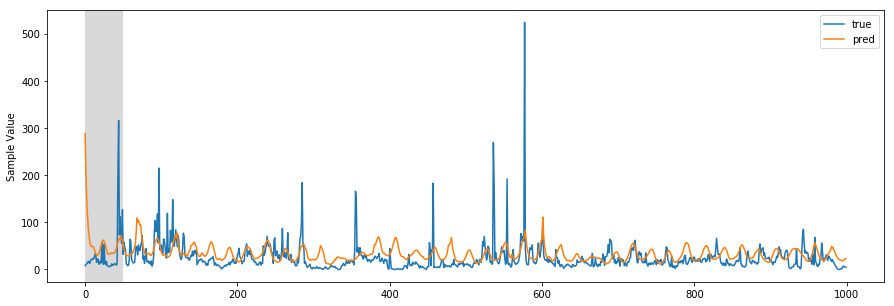

In [95]:
plot_comparison(500, 1000, False)